In [49]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt


import keras
from keras import layers
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, F1Score
import tensorflow as tf

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [6]:
# Transform when using Colab
ratings_df = pd.read_pickle('/content/drive/My Drive/ML_Assignments/ML_Group/df_ratings_cleaned.pkl')
movies_df = pd.read_pickle('/content/drive/My Drive/ML_Assignments/ML_Group/df_movies_cleaned.pkl')

In [7]:
# transform pickle file to pandas dataframe
#ratings_df = pd.read_pickle('data/df_ratings_cleaned.pkl')
#movies_df = pd.read_pickle('data/df_movies_cleaned.pkl')

## Stratified Sampling 3M Ratings

In [9]:
# We will use pandas' cut function to categorize these ratings
ratings_df['rating_category'] = pd.cut(ratings_df['rating'], bins=np.arange(0.5, 6.0, 0.5), include_lowest=True, right=False)

# Stratified sampling based on rating categories
ratings_df_3M = ratings_df.groupby('rating_category', group_keys=False).apply(
    lambda x: x.sample(int(np.rint(3000000 * len(x) / len(ratings_df))), random_state=42)
)

print(f"Original DF Shape: {ratings_df.shape}")
print(f"Sampled DF Shape: {ratings_df_3M.shape}")

Original DF Shape: (24829828, 7)
Sampled DF Shape: (3000001, 7)


Now that we have downsampled the ratings dataset, we can compare the summary statistics of the original and downsampled datasets to ensure that the distribution of ratings has been maintained.

In [10]:
# Compare summary statistics of the original and downsampled datasets
def summary_stats_comparison(original_df, downsampled_df, column):
    """Compare summary statistics of a column in the original and downsampled datasets."""
    original_stats = original_df[column].describe()
    downsampled_stats = downsampled_df[column].describe()

    summary_stats = pd.concat([original_stats, downsampled_stats], axis=1)
    summary_stats.columns = ['Original', 'Sampled']

    return summary_stats

summary_stats_comparison(ratings_df, ratings_df_3M, 'rating')

,Original,Sampled
count,24829828.0,3000001.0
mean,3.52898,3.528979
std,1.060177,1.060178
min,0.5,0.5
25%,3.0,3.0
50%,3.5,3.5
75%,4.0,4.0
max,5.0,5.0


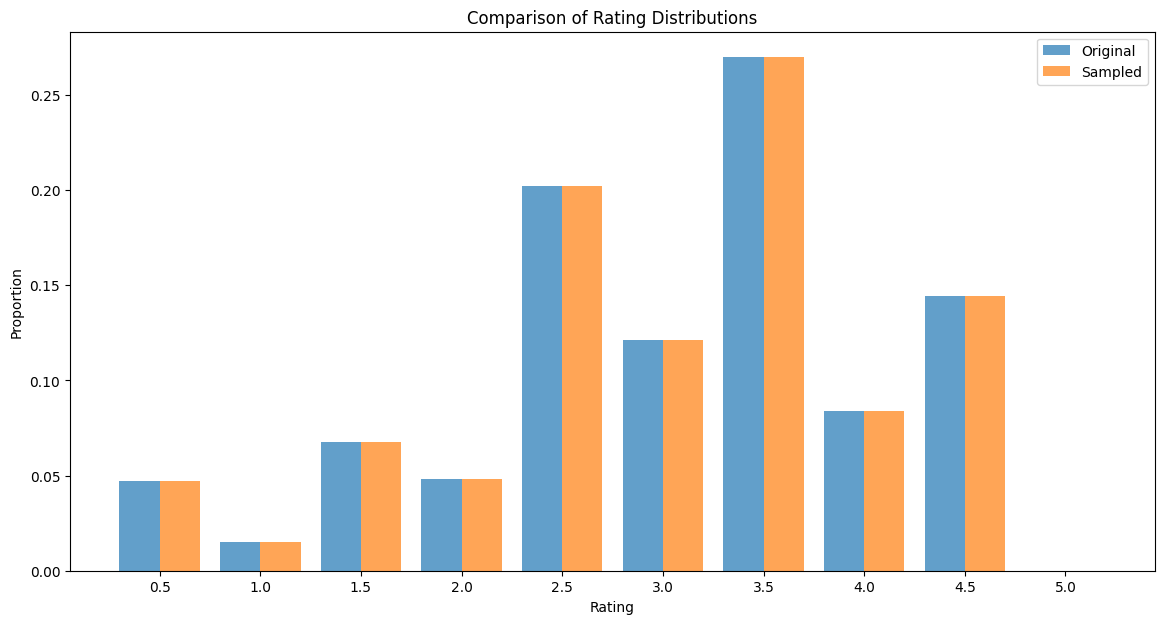

In [11]:
# Define bins
bins = np.arange(0.5, 6.0, 0.5)

# Calculate bin centers
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# Define width of each bar
bar_width = 0.2

# Plot histograms
plt.figure(figsize=(14, 7))
plt.bar(bin_centers - bar_width/2, ratings_df['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Original', align='center')
plt.bar(bin_centers + bar_width/2, ratings_df_3M['rating'].value_counts(normalize=True, sort=False, bins=bins), width=bar_width, alpha=0.7, label='Sampled', align='center')

plt.title('Comparison of Rating Distributions')
plt.xlabel('Rating')
plt.ylabel('Proportion')
plt.xticks(bin_centers, labels=[f"{bin:.1f}" for bin in bins[:-1]])  # Set x-tick labels to match bin centers
plt.legend()
plt.show()

In [12]:
ratings_df_3M.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"


In [13]:
# Save the downsampled datasets to a pickle file
#ratings_df_3M.to_pickle('data/df_ratings_3M.pkl')

## Ratings Preprocessing

In [22]:
df_merged = pd.read_pickle('/content/drive/My Drive/ML_Assignments/ML_Group/df_merged_cleaned.pkl')

df_ratings = pd.read_pickle('/content/drive/My Drive/ML_Assignments/ML_Group/df_ratings_3M.pkl') # Adjust the dataset depending on the size needed

In [23]:
df_ratings.head()

,userId,movieId,rating,timestamp,user_mean_rating,liked_by_user,rating_category
11800835,128365,1037,0.5,2009-10-19 10:10:37,3.104895,False,"[0.5, 1.0)"
3192182,34770,27316,0.5,2006-06-10 09:14:33,1.329146,False,"[0.5, 1.0)"
10041143,108700,307,0.5,2010-05-12 21:26:12,3.729651,False,"[0.5, 1.0)"
14911364,162680,73929,0.5,2015-11-22 18:22:29,3.505618,False,"[0.5, 1.0)"
13024846,141941,4308,0.5,2006-06-10 05:21:47,2.987685,False,"[0.5, 1.0)"


In [24]:
# Make sure that the timestamp is in seconds
df_ratings['timestamp'] = df_ratings['timestamp'].astype('int64') // 10**9

# Keep only relevant columns
df_ratings = df_ratings[['userId', 'movieId', 'rating', 'timestamp']]

# Make userId the index
#df_ratings.set_index('userId', inplace=True)

# Delete index
df_ratings.reset_index(drop=True, inplace=True)

df_ratings.head()

,userId,movieId,rating,timestamp
0,128365,1037,0.5,1255947037
1,34770,27316,0.5,1149930873
2,108700,307,0.5,1273699572
3,162680,73929,0.5,1448216549
4,141941,4308,0.5,1149916907


## Movies Preprocessing

In [25]:
df_merged.head()

,movieId,belongs_to_collection,original_language,overview,release_date,runtime,title,actors,keywords_extracted,genre_extracted,production_company_extracted,production_country_extracted
0,1,1,en,"Led by Woody, Andy's toys live happily in his ...",1995-10-30,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...","[jealousy, toy, boy, friendship, friends, riva...","[Animation, Comedy, Family]",[Pixar Animation Studios],[United States of America]
1,2,0,en,When siblings Judy and Peter discover an encha...,1995-12-15,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...","[board game, disappearance, based on children'...","[Adventure, Fantasy, Family]","[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America]
2,3,1,en,A family wedding reignites the ancient feud be...,1995-12-22,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...","[fishing, best friend, duringcreditsstinger, o...","[Romance, Comedy]","[Warner Bros., Lancaster Gate]",[United States of America]
3,4,0,en,"Cheated on, mistreated and stepped on, the wom...",1995-12-22,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...","[based on novel, interracial relationship, sin...","[Comedy, Drama, Romance]",[Twentieth Century Fox Film Corporation],[United States of America]
4,5,1,en,Just when George Banks has recovered from his ...,1995-02-10,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...","[baby, midlife crisis, confidence, aging, daug...",[Comedy],"[Sandollar Productions, Touchstone Pictures]",[United States of America]


In [26]:
# Keep only relevant columns
df_movies = df_merged[['movieId', 'title', 'genre_extracted']]

df_movies.head()

,movieId,title,genre_extracted
0,1,Toy Story,"[Animation, Comedy, Family]"
1,2,Jumanji,"[Adventure, Fantasy, Family]"
2,3,Grumpier Old Men,"[Romance, Comedy]"
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II,[Comedy]


In [27]:
# Function to transform list of genres into a pipe-separated string
def transform_genre(genres_list):
    # Join list elements with a pipe
    return '|'.join(genres_list)

# Apply the transformation
df_movies['genres'] = df_movies['genre_extracted'].apply(transform_genre)

# drop the genre_extracted column
df_movies.drop('genre_extracted', axis=1, inplace=True)

# Display the transformed DataFrame
df_movies.head()

<ipython-input-27-ca26d42be627>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies['genres'] = df_movies['genre_extracted'].apply(transform_genre)
<ipython-input-27-ca26d42be627>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_movies.drop('genre_extracted', axis=1, inplace=True)


,movieId,title,genres
0,1,Toy Story,Animation|Comedy|Family
1,2,Jumanji,Adventure|Fantasy|Family
2,3,Grumpier Old Men,Romance|Comedy
3,4,Waiting to Exhale,Comedy|Drama|Romance
4,5,Father of the Bride Part II,Comedy


In [28]:
user_ids = df_ratings["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df_ratings["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df_ratings["user"] = df_ratings["userId"].map(user2user_encoded)
df_ratings["movie"] = df_ratings["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df_ratings["rating"] = df_ratings["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df_ratings["rating"])
max_rating = max(df_ratings["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 164638, Number of Movies: 26876, Min rating: 0.5, Max rating: 5.0


# Prepare data for training

In [29]:
df = df_ratings.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

# Create the model

We can create a custom model by subclassing the `keras.Model` class. The `RecommenderNet` class is a deep learning model built using the Keras framework, specifically designed to recommend movies to users. The model is part of a collaborative filtering system, which predicts what movies users might like based on their past interactions.
In the `__init__` method, we will define the embedding layers for users and movies. We will also define the user and movie biases. In the `call` method, we will define the forward pass of the model. We will get the user and movie embeddings and biases, compute the dot product of the user and movie embeddings, and add the biases to get the final rating prediction. We will use the sigmoid activation function to ensure that the predicted ratings are between 0 and 1.

In [53]:
EMBEDDING_SIZE = 50


class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

    def build(self, input_shape):
        self.user_embedding = layers.Embedding(
            input_dim=self.num_users,
            output_dim=self.embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.movie_embedding = layers.Embedding(
            input_dim=self.num_movies,
            output_dim=self.embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(input_dim=self.num_users, output_dim=1)
        self.movie_bias = layers.Embedding(input_dim=self.num_movies, output_dim=1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        user_bias = self.user_bias(inputs[:, 0])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)


model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics=['accuracy', Precision(), Recall(), F1Score()]
)


# Train the model

In [54]:
# Train the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/5
42188/42188 [==============================] - 270s 6ms/step - loss: 0.6613 - accuracy: 0.1454 - precision_2: 0.9917 - recall: 0.8172 - f1_score: 0.8046 - val_loss: 0.6487 - val_accuracy: 0.1467 - val_precision_2: 0.9911 - val_recall: 0.8539 - val_f1_score: 0.8047
Epoch 2/5
42188/42188 [==============================] - 267s 6ms/step - loss: 0.6410 - accuracy: 0.1466 - precision_2: 0.9922 - recall: 0.8167 - f1_score: 0.8046 - val_loss: 0.6365 - val_accuracy: 0.1483 - val_precision_2: 0.9910 - val_recall: 0.8874 - val_f1_score: 0.8047
Epoch 3/5
42188/42188 [==============================] - 267s 6ms/step - loss: 0.6240 - accuracy: 0.1490 - precision_2: 0.9923 - recall: 0.8478 - f1_score: 0.8046 - val_loss: 0.6232 - val_accuracy: 0.1490 - val_precision_2: 0.9913 - val_recall: 0.8873 - val_f1_score: 0.8047
Epoch 4/5
42188/42188 [==============================] - 267s 6ms/step - loss: 0.6127 - accuracy: 0.1500 - precision_2: 0.9925 - recall: 0.8572 - f1_score: 0.8046 - val_loss: 

# Evaluate the model

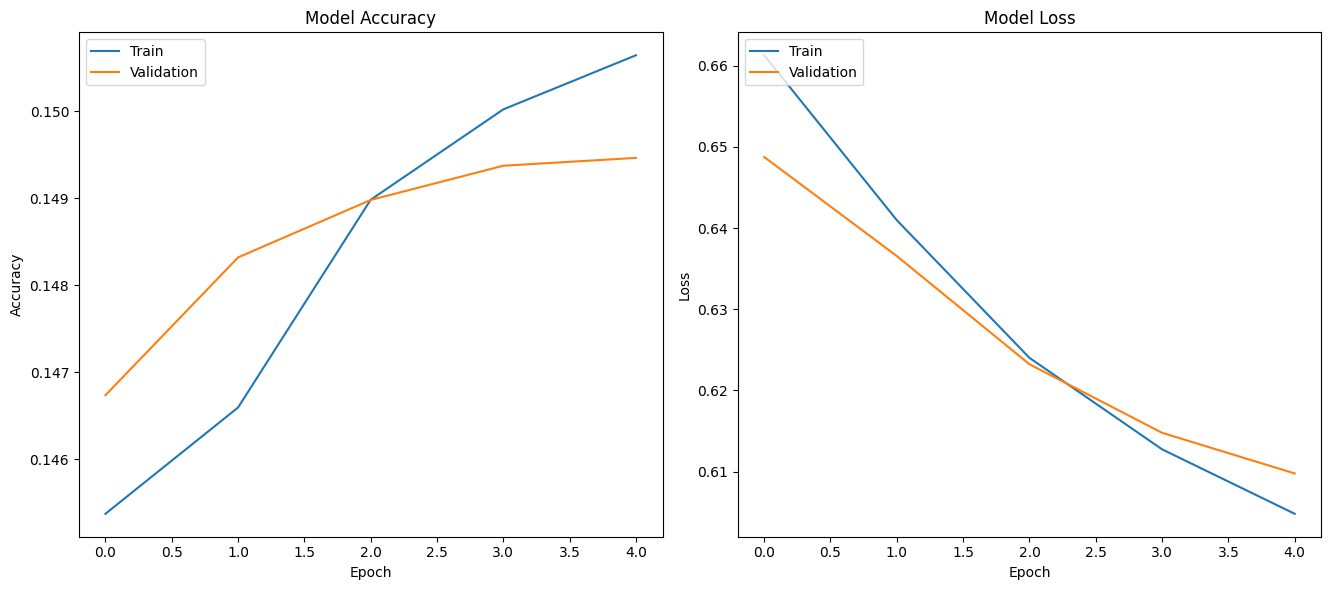

Total number of parameters: 9767214


In [56]:
# Define a function to plot the training history
def plot_history(history):
    fig = plt.figure(figsize=(20, 6))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)

    # Plot accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_history(history)

# Print the total number of parameters in the model
total_params = model.count_params()
print("Total number of parameters:", total_params)

1. Model Accuracy Plot:

- Training Accuracy: It is decreasing over epochs, which is unusual for a typical training scenario. This suggests the model may be struggling to learn or generalize even from the training data.
- Validation Accuracy: It follows a similar downward trend as the training accuracy, indicating that the model is consistently performing poorly on both training and unseen validation data. This pattern further emphasizes issues in the model's learning capability or possible problems with the data itself.

2. Model Loss Plot:

- Training Loss: Increasing consistently over epochs. Normally, you would expect the training loss to decrease if the model is learning effectively.
- Validation Loss: It closely mirrors the training loss, indicating that the model is equally not improving on the validation set. The parallel increase in loss for both training and validation suggests a systemic issue, such as inappropriate model architecture, learning rate, or simply that the model is not suitable for the data characteristics.

Possible Issues:

- Underfitting: The model might be too simple to capture the underlying pattern of the data.
- Inappropriate Learning Rate: If the learning rate is too high, the model may overshoot the optimal points during training.

We will now inspect the metrics of the best epoch

In [58]:
import numpy as np

# Assuming 'history' is the output of the training process
val_f1_scores = history.history['val_f1_score']
best_epoch = np.argmax(val_f1_scores)  # Index of best epoch

print("Best Epoch:")
print(f"Epoch {best_epoch + 1}")
print(f"Training Loss: {history.history['loss'][best_epoch]}")
print(f"Validation Loss: {history.history['val_loss'][best_epoch]}")
print(f"Training Accuracy: {history.history['accuracy'][best_epoch]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][best_epoch]}")
print(f"Training Precision: {history.history['precision_2'][best_epoch]}")
print(f"Validation Precision: {history.history['val_precision_2'][best_epoch]}")
print(f"Training Recall: {history.history['recall'][best_epoch]}")
print(f"Validation Recall: {history.history['val_recall'][best_epoch]}")
print(f"Training F1 Score: {history.history['f1_score'][best_epoch]}")
print(f"Validation F1 Score: {history.history['val_f1_score'][best_epoch]}")


Best Epoch:
Epoch 1
Training Loss: 0.6612700819969177
Validation Loss: 0.648743212223053
Training Accuracy: 0.14537444710731506
Validation Accuracy: 0.14673617482185364
Training Precision: 0.9916500449180603
Validation Precision: 0.9911080598831177
Training Recall: 0.8171944618225098
Validation Recall: 0.8539382219314575
Training F1 Score: [0.8046124]
Validation F1 Score: [0.80467474]


- Loss: It seems that both the training and validation loss decreased consistently across epochs, which is a good sign that the model is learning effectively from the training data and generalizing well to unseen data.
- Accuracy: The accuracy remains fairly low and changes slightly, suggesting that accuracy might not be the best metric for this problem, especially if the data is imbalanced or if the model's task involves predicting a minority class.
- Precision: Very high precision across all epochs indicates that the model is very good at not labeling negative samples as positive. However, given the nature of the data and problem, this might also indicate that the model is biased towards predicting the majority class (likely the negative class if the data is imbalanced -> we will check this further below).
- Recall: The recall has increased across epochs, which means the model is getting better at identifying all positive samples.
- F1 Score: The F1 score remains consistent across epochs, which suggests that the balance between precision and recall is stable.

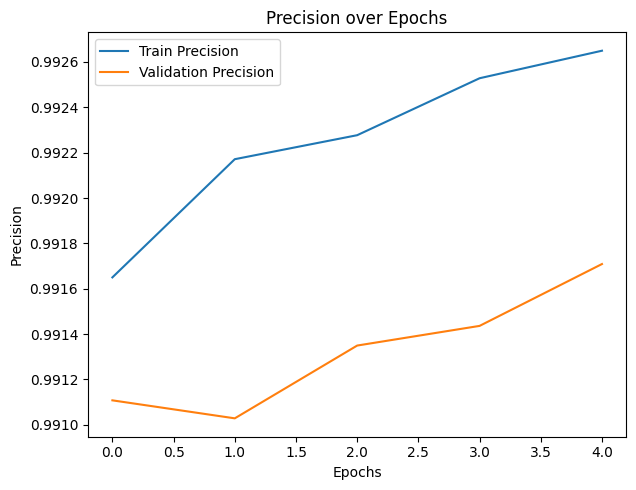

In [59]:
# Plot the precision metric
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision_2'], label='Train Precision')
    plt.plot(history.history['val_precision_2'], label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

**Interpretation**:
- Rapid Increase: The model's precision for the training set shows a consistent increase throughout the epochs, suggesting that the model is continually learning and improving its ability to correctly identify positive examples as such.
- Divergence: There's a noticeable divergence between training and validation precision, especially after the first epoch. This might suggest overfitting, where the model performs increasingly well on the training data but less so on the validation data. The precision on the validation set initially increases but then starts to decrease, which supports the idea of overfitting.

**Class Imbalance:** The extremely high precision combined with relatively low accuracy, as previously discussed, does indicate potential class imbalance. The model is likely predicting the majority class (assumed to be negatives) more frequently because there are fewer positive samples.

**Steps to Adjust:**

1. Handle Class Imbalance:

- Resampling Techniques: Either undersample the majority class or oversample the minority class in the training set.
Adjust Class Weights: Modify the loss function to penalize wrong predictions on the minority class more than wrong predictions on the majority class.

2. Model Adjustments:

- Regularization: Implement or increase regularization techniques (like dropout or L2 regularization) to reduce overfitting.
- Early Stopping: Monitor validation loss and stop training when it begins to increase, despite improvements in training loss.

3. Learning Rate Adjustments:

- Decrease Learning Rate: If precision improves but then degrades, it might be useful to lower the learning rate as training progresses. This can help the model make smaller updates to weights and potentially avoid overfitting.

We will now check if the data is imbalanced:

In [51]:
# Define a new column for class based on the rating
df_ratings['class'] = (df_ratings['rating'] >= 4).astype(int)  # 1 for 'like', 0 for 'dislike'

# Count the number of instances in each class
class_counts = df_ratings['class'].value_counts()

# Calculate the proportion of each class
class_proportions = class_counts / len(df_ratings)

print("Class Counts:\n", class_counts)
print("Class Proportions:\n", class_proportions)

Class Counts:
 class
0    1504847
1    1495154
Name: count, dtype: int64
Class Proportions:
 class
0    0.501615
1    0.498385
Name: count, dtype: float64


The distribution looks good.

However, there are further recommendations for next steps:

- Early Stopping: Implement early stopping in the training loop to stop training when the validation precision starts to degrade.

- Regularization and Dropout: Introduce or increase dropout or regularization in the network to combat overfitting.

- Cross-validation: Use k-fold cross-validation to ensure that the model’s evaluation is as robust as possible and not overly dependent on the way the data is split.

# Make movie recommendations

In [72]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = df_movies[
    ~df_movies["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = df_movies[df_movies["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = df_movies[df_movies["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

785/785 [==============================] - 1s 1ms/step
Showing recommendations for user: 95718
Movies with high ratings from user
--------------------------------
Schindler's List : Drama|History|War
Die Hard : Action|Thriller
Butch Cassidy and the Sundance Kid : History|Drama|Western|Crime
Seven Days in May : Drama|Thriller
The Professional : Action|Adventure|Thriller
--------------------------------
Top 10 movie recommendations
--------------------------------
Pather Panchali : Drama
Children of Heaven : Drama|Comedy|Family
Children of Paradise : Drama|Romance
Time of the Gypsies : Drama|Comedy|Crime|Fantasy
Ikiru : Drama
Le Cercle Rouge : Drama|Thriller|Crime
Werckmeister Harmonies : Drama
Sigur Rós: Heima : Music
Heart of a Dog : Drama|Comedy|Science Fiction
Doctor Who: A Christmas Carol : (none)


- "Schindler's List" is a critically acclaimed drama with profound historical themes.
- "Die Hard" is a popular action/thriller that has wide appeal.

This shows that the user has a preference for intense dramas and thrilling action films, possibly with complex narratives and significant emotional or historical weight.

The recommended movies appear to be well-aligned with the user's interest in dramas, as indicated by the high ratings for dramatic films. The recommendations include:

- "Pather Panchali", "Children of Heaven", "Children of Paradise", and "Ikiru" are all films that are renowned for their powerful storytelling and dramatic depth.
- The inclusion of "Le Cercle Rouge" and "Time of the Gypsies" suggests the system is also picking up on the user’s interest in crime and thriller elements combined with drama.

**Interpretation of Recommendation Quality**
- Relevance to User Preferences: The system seems to have accurately modeled the user's preference for dramas that carry significant narrative depth or artistic value. The inclusion of genres like crime and thriller in the recommended list suggests that the system is also considering other aspects of the user's preferences.
- Diversity of Recommendations: There's a good diversity within the drama category itself, ranging from pure dramas to those mixed with other genres (comedy, crime, fantasy), which might help in keeping the user engaged by not limiting the suggestions to a single tone or style.